<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
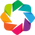

In [115]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geoviews as gv
import geoviews.tile_sources as gvts
import geoviews.feature as gf
from geoviews import dim, opts
gv.extension('bokeh')
csv_file = '../Data_Cleanup/outCSV/Station_ID_with_AvgIdleDaytimesDays_and_lonlat.csv'
df = pd.read_csv(csv_file)

In [32]:
df["idle_time"] = pd.to_timedelta(df["idle_time"])
sorted_df = df.sort_values(by="idle_time", ascending=False)
sorted_df.head(11)

,end_station_id,idle_time,morgens,vormittags,mittags,nachmittags,abends,nachts,monday,tuesday,wednesday,thursday,friday,saturday,sunday,end_station_lat,end_station_lon
399,4640,138 days 18:52:31.428571428,5,5,5,5,6,4,4,4,4,6,3,3,3,[-90.],[0.]
217,4403,53 days 17:21:18.947368421,12,18,7,1,1,9,1,1,1,1,1,1,19,[33.943359],[-118.248238]
69,4125,7 days 11:50:23.845360824,78,80,77,78,71,77,54,56,56,56,57,53,59,[33.766659],[-118.261017]
196,4373,5 days 05:37:00,1,1,1,1,1,1,1,1,1,1,1,0,1,[34.03677],[-118.425377]
66,4108,4 days 00:28:46.183246073,103,84,87,64,56,80,48,44,49,42,38,47,34,[34.02589],[-118.238243]
8,3013,3 days 11:35:12.737430167,119,123,122,115,103,116,65,68,78,73,79,73,96,[33.779819],[-118.263023]
298,4500,2 days 21:41:21.379310344,44,59,60,50,40,43,30,26,25,33,35,29,26,[34.1721],[-118.361816]
197,4374,2 days 11:59:53.333333333,13,9,12,11,8,9,8,8,7,11,7,8,5,[34.036621],[-118.425308]
299,4502,2 days 08:51:00.967741935,79,80,68,66,69,82,32,37,31,45,42,35,40,[34.16552],[-118.375153]
79,4136,2 days 07:23:05.953795379,222,231,211,215,196,226,95,102,109,120,102,124,117,[33.771759],[-118.276543]


We can see that the station 4403 has an unnormal idle_time, my first idea would be to filter the original data by the station id and plot the idle_time of each trip against the start time of the trip

In [33]:
full_data = pd.read_csv("../Data_Cleanup/outCSV/Metro_Set_DayAndDayTimes.csv", index_col=0)
full_data.info()

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_86390/2694805513.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv("../Data_Cleanup/outCSV/Metro_Set_DayAndDayTimes.csv", index_col=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 0 to 1552781
Data columns (total 26 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0.2       1552782 non-null  int64  
 1   Unnamed: 0.1       1552782 non-null  int64  
 2   Unnamed: 0         1552782 non-null  int64  
 3   start_time         1552782 non-null  object 
 4   end_time           1552782 non-null  object 
 5   start_station_id   1552782 non-null  int64  
 6   start_station_lat  1552782 non-null  float64
 7   start_station_lon  1552782 non-null  float64
 8   end_station_id     1552782 non-null  int64  
 9   end_station_lat    1552782 non-null  float64
 10  end_station_lon    1552782 non-null  float64
 11  bike_id            1552782 non-null  object 
 12  idle_time          1182789 non-null  object 
 13  morgens            1552782 non-null  int64  
 14  vormittags         1552782 non-null  int64  
 15  mittags            1552782 non-n

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_86390/2999342749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)


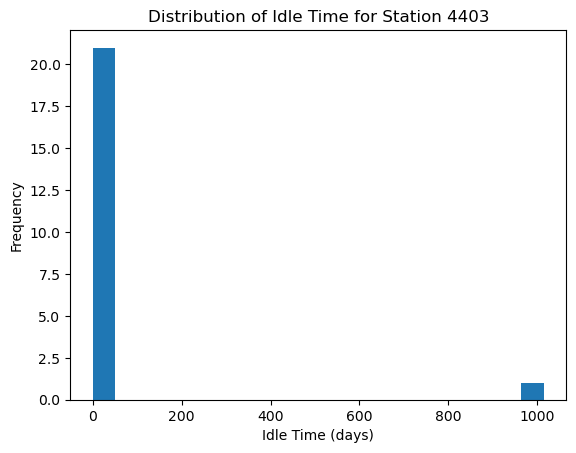

In [34]:
# Filter the rows for the station with ID 4403
station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]

# Convert the idle_time column to numeric values in days
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)

# Create a histogram of idle_time values
plt.hist(station_data['idle_time'], bins=20)
plt.xlabel('Idle Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Time for Station 4403')
plt.show()


Looking at the Histogramm we can see that we have around 40 rows that has more than 1000 days in idle time.
It seems tht there has been a huge break in the usage in this station, let try to find it.

In [35]:
station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]
station_data['start_time'] = pd.to_datetime(station_data["start_time"])
station_data['end_time'] = pd.to_datetime(station_data["end_time"])

# Convert 'idle_time' column to Timedelta
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time'])
# Filter the rows for the station with ID 4403 and idle_time over 1000 days
long_idle_trips = station_data[station_data["idle_time"] > pd.Timedelta(days=1000)]
# Sort the trips by end_time in ascending order
long_idle_trips = long_idle_trips.sort_values('end_time')

# Initialize an empty DataFrame to store the comparison results
comparison_results = pd.DataFrame(columns=['Trip', 'End Time', 'Next Start Time'])

# Iterate over the rows of the long_idle_trips DataFrame
for index, row in long_idle_trips.iterrows():
    end_time = row['end_time']
    for index, row in station_data.iterrows():
        if row["start_time"] > end_time:
            next_start_time = row["start_time"]
    comparison_results = pd.concat([comparison_results, pd.DataFrame({'Trip': [index], 'End Time': [end_time], 'Next Start Time': [next_start_time]})], ignore_index=True)

# Print the comparison results
print(comparison_results)


      Trip            End Time     Next Start Time
0  1532899 2022-12-04 09:21:00 2022-12-04 14:54:00


/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_86390/4193587343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['start_time'] = pd.to_datetime(station_data["start_time"])
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_86390/4193587343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['end_time'] = pd.to_datetime(station_data["end_time"])
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_86390/4193587343.py:6: SettingWithCopyWarning: 
A value i

Looking at the data we can see that no one used the station between 2020-02-23 15:09:00 and 2022-12-04 14:54:00

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_86390/3023516580.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_stations["end_station_id"] = top_10_stations["end_station_id"].astype(str)


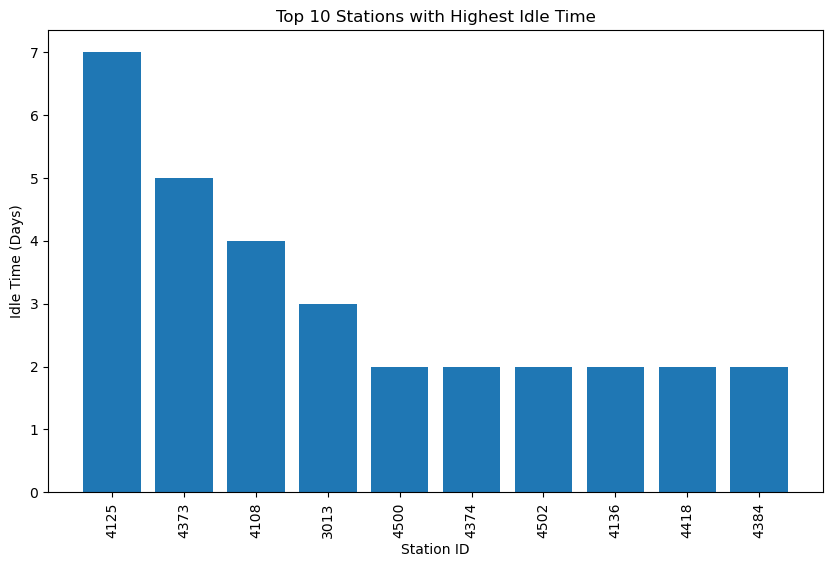

In [36]:
import matplotlib.pyplot as plt

# Filter the sorted_df to exclude outliers with more than 30 days of idle time
filtered_df = sorted_df[sorted_df['idle_time'] <= pd.Timedelta(days=30)]

# Take the top 10 stations with the highest idle time
top_10_stations = filtered_df.head(10)

# Convert the end_station_id to string
top_10_stations["end_station_id"] = top_10_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_stations["end_station_id"], top_10_stations["idle_time"].dt.days)

# Set the chart title and axis labels
plt.title("Top 10 Stations with Highest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Days)")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()


/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_86390/923204609.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_10_stations["end_station_id"] = bottom_10_stations["end_station_id"].astype(str)


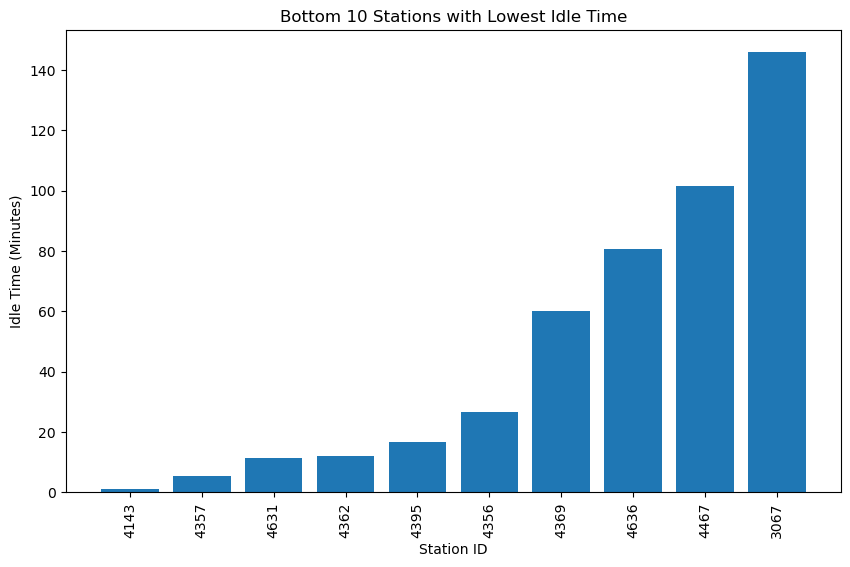

In [37]:
import matplotlib.pyplot as plt

# Sort the dataframe by idle_time in ascending order
df["idle_time"] = pd.to_timedelta(df["idle_time"])
sorted_df = df.sort_values(by="idle_time")

# Filter out outliers with more than 30 days of idle time
filtered_df = sorted_df[sorted_df["idle_time"] <= pd.Timedelta(days=30)]

# Select the bottom 10 stations with the lowest idle time
bottom_10_stations = filtered_df.head(10)

# Convert the end_station_id to string
bottom_10_stations["end_station_id"] = bottom_10_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(bottom_10_stations["end_station_id"], bottom_10_stations["idle_time"].dt.total_seconds()/60)

# Set the chart title and axis labels
plt.title("Bottom 10 Stations with Lowest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Minutes)")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()


#### Geographical Data Visalization
In this section, we will further visualize the exact coordinates of the bike stations on a Los Angeles map and therefore enable the marketing section to further analize how location of the stations may be connected to its idle time, e.g. its productiveness.
As we only need the geographical data of each station, and its ID and idle time, we can create a new DataFrame and leave out the rest of the information.


In [152]:
df = pd.read_csv("../Data_Cleanup/outCSV/Station_ID_with_AvgIdleDaytimesDays_and_lonlat.csv")
df = df.drop(df.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1)
df['end_station_lat'] = df['end_station_lat'].str[1:-1].astype(np.float64)
df['end_station_lon'] = df['end_station_lon'].str[1:-1].astype(np.float64)
df["idle_time"] = pd.to_timedelta(df["idle_time"]).dt.total_seconds()/60/60

#df['location'] = df.apply(lambda row: row['end_station_lon'] + row['end_station_lat'], axis=1)
df.head()

,end_station_id,idle_time,end_station_lat,end_station_lon
0,3000,9.934171,34.048500,-118.258537
1,3005,3.947014,34.048500,-118.258537
2,3006,3.161311,34.045540,-118.256668
3,3007,4.588129,34.050480,-118.254593
4,3008,3.886666,34.046612,-118.262733


In [155]:

df_points = gv.Points(df, ["end_station_lon", "end_station_lat"] )

In [158]:
airports_plot = (gvts.CartoLight * df_points).opts(
    opts.Points(width=1200, height=700, alpha=0.3,
                color=dim('color'), hover_line_color='black',
                line_color='black', xaxis=None, yaxis=None,
                tools=['hover'],size=np.sqrt(dim('idle_time')*10)))  * df_points
airports_plot

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [end_station_lon,end_station_lat]   (end_station_id,idle_time)
   .Points.II :Points   [end_station_lon,end_station_lat]   (end_station_id,idle_time)

In [184]:
import folium
import pandas as pd
from folium import plugins
from folium.plugins import HeatMap

# Latitude and Longitude coordinates of Los Angeles
la_coordinates = (34.0522, -118.2437)

# Create a folium map centered on Los Angeles
map_la = folium.Map(location=la_coordinates, zoom_start=11)

# Iterate over the rows of the DataFrame
heatlist = []
for index, row in df.iterrows():
    station_id = row['end_station_id']
    lat = float(row['end_station_lat'])
    lon = float(row['end_station_lon'])
    idle = float(row["idle_time"])
    heatlist.append([lat, lon, np.sqrt(idle)])

    # Add a marker for each station to the map
    folium.CircleMarker(location=[lat, lon], tooltip=str(station_id), radius = np.sqrt(idle*2)).add_to(map_la)

#Add a Heatmap
HeatMap(data= heatlist).add_to(map_la)
# Display the map
map_la